In [1]:
import arviz as az
#import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr
import scipy as sp

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.10.3


This notebook uses a more advanced technique in Bayesian statistics, namely Dirichlet Processes (DP). This is a very flexible random object that is able to generate random Dirichlet distributions, which itself is a multidimensional Beta distribution. To put it easier, a Dirichlet distribution is a list of probabilities (summing to one), each representing the probability to be in a class. The counts of classes is Multinomially distributed, which is nothing more than a Binomial distribution with more than two classes.

The Dirichlet Process itself it infinite dimensional, meaning that it has (in theory) an infinite number of probabilities which cannot be stored in a computer. The so-called stick-breaking process is a finite approximation of the DP. Without going into further detail, we will show its power in fitting mixture distributions. In short, suppose suppose a response variable comes from multiple groups, but the underlying groups are unknown, the underlying groups can be exposed by the method shown below.

We define four groups with means 1, 4, 7 and 10, occurring with probabilities 30%, 25% 30% and 15% respectively.

In [2]:
def stick_breaking(beta):
    portion_remaining = pt.concatenate([[1], pt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

C:\Users\gouwenss\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


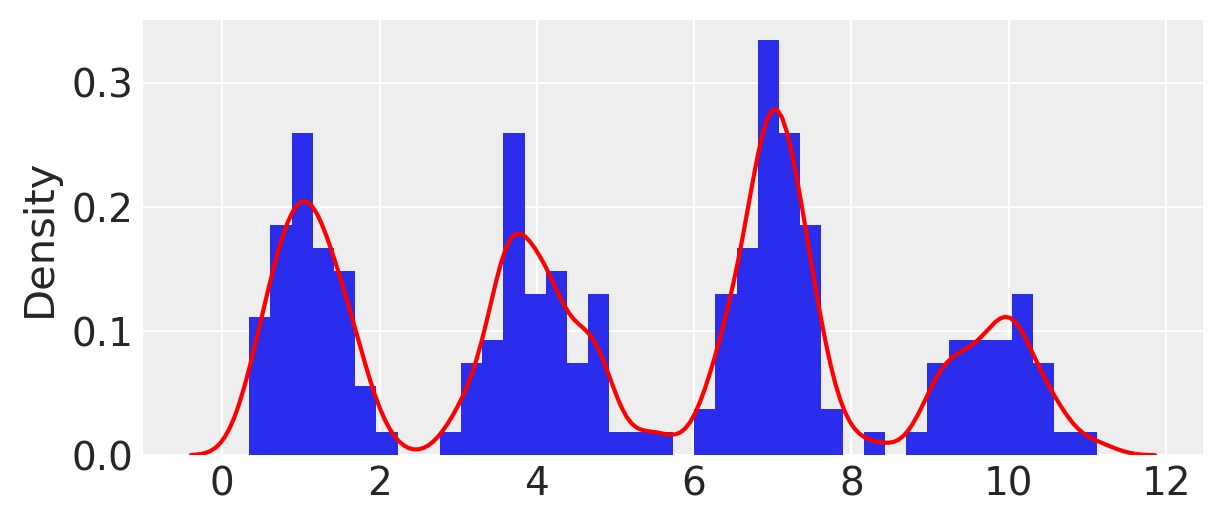

In [6]:
# From here, we attempt to make a mixture logistic model with Dirichlet Process prior
K = 20
N = 200

k = np.random.choice([1,4,7,10], N, replace=True, p=[.3,.25,.3,.15])
y = np.random.normal(k, .5, N)

fig, ax = plt.subplots(figsize=(6,2.5))
ax.hist(y, bins=40, density=True, color="C0", lw=0)
sns.kdeplot(y, bw_method=0.08, c='red')
plt.show()

Below the model is specified. The stick-breaking method approximating the DP has a parameter $\alpha$. This parameter represents in what proportions the stick is broken. We do not specify this value, but rather give it a prior with little mass for high values.

The stick-breaking process generates proportions (in our case, the probability of each of the 4 mixture components). Each mixture component gets a prior of its location and standard deviation. The hierarchical structure is shown below.

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 27200
Interrupted at 27,199 [13%]: Average Loss = 567.12
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, mu, sigma]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 876 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 796 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


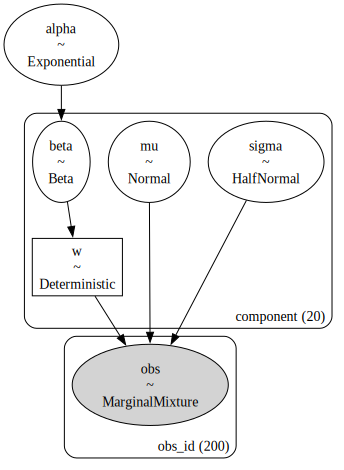

In [7]:
with pm.Model(coords={"component": np.arange(K), 
                      "obs_id": np.arange(N)}) as model_dp:

    # Stick breaking process to generate the Dirichlet Process
    alpha = pm.Exponential("alpha", 2)
    beta = pm.Beta("beta", 1.0, alpha, dims="component")
    w = pm.Deterministic("w", stick_breaking(beta), dims="component")

    # Defining the mixture logistic with weights w from the Dirichlet Process
    mu = pm.Normal(name='mu', mu=5, sigma=5, dims="component")
    sigma = pm.HalfNormal(name='sigma', sigma=1, dims="component")

    # Likelihood, containing observations
    obs = pm.NormalMixture("obs", w=w, mu=mu, sigma=sigma, observed=y, dims="obs_id")

with model_dp:
    trace = pm.sample(tune=500,
                      init="advi",
                      target_accept=0.9,
                      random_seed=RANDOM_SEED)

pm.model_to_graphviz(model_dp)

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

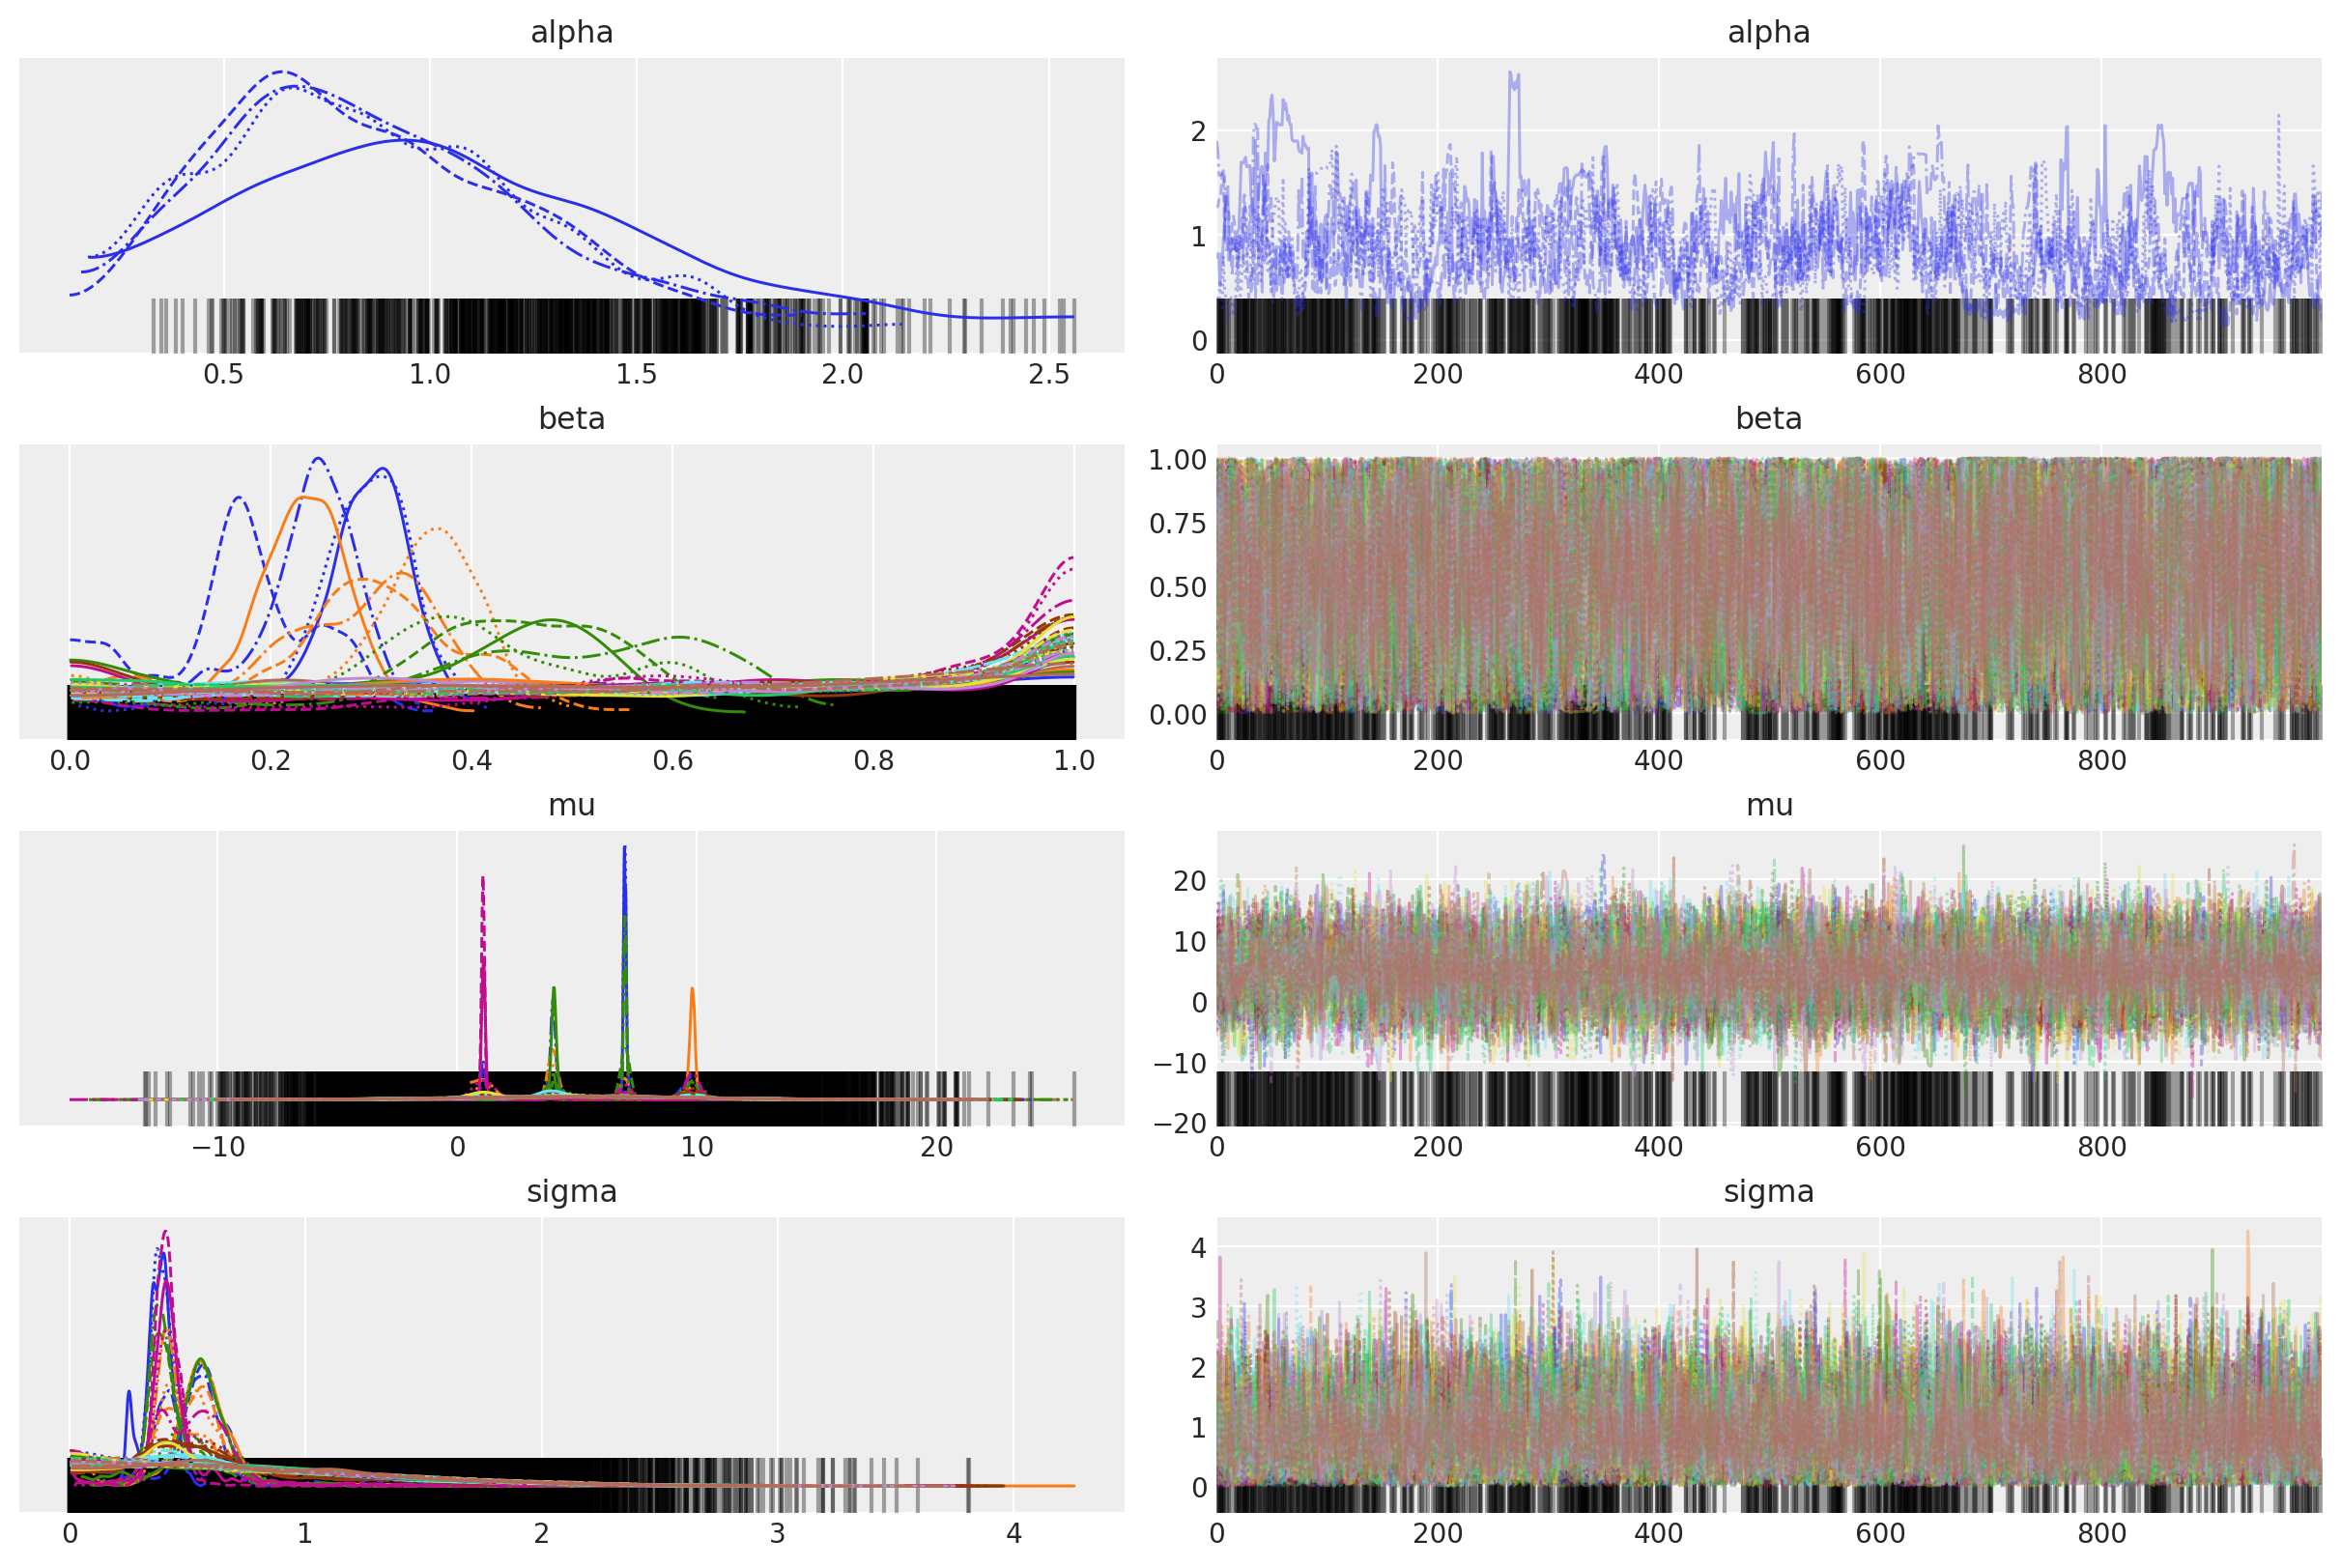

In [8]:
az.plot_trace(trace, var_names=["alpha", 'beta', "mu", "sigma"]) 

Recall the values of the mixture having 4 modes with means 1, 4, 7 and 10. In the posterior plot of the weights "mu" peaks are visible at exactly these points.

However, the stick-breaking process generates K=20 probabilities. We can check how much of the total probability of 100% is distributed among 4 groups. If 4 groups take up the majority of the weight, the model is good. If it were clear beforehand how many groups there are, it would be better to use a Dirichlet process prior with 4 probabilities. The power of the DP lies in the fact that the number of groups does not need to be specified.

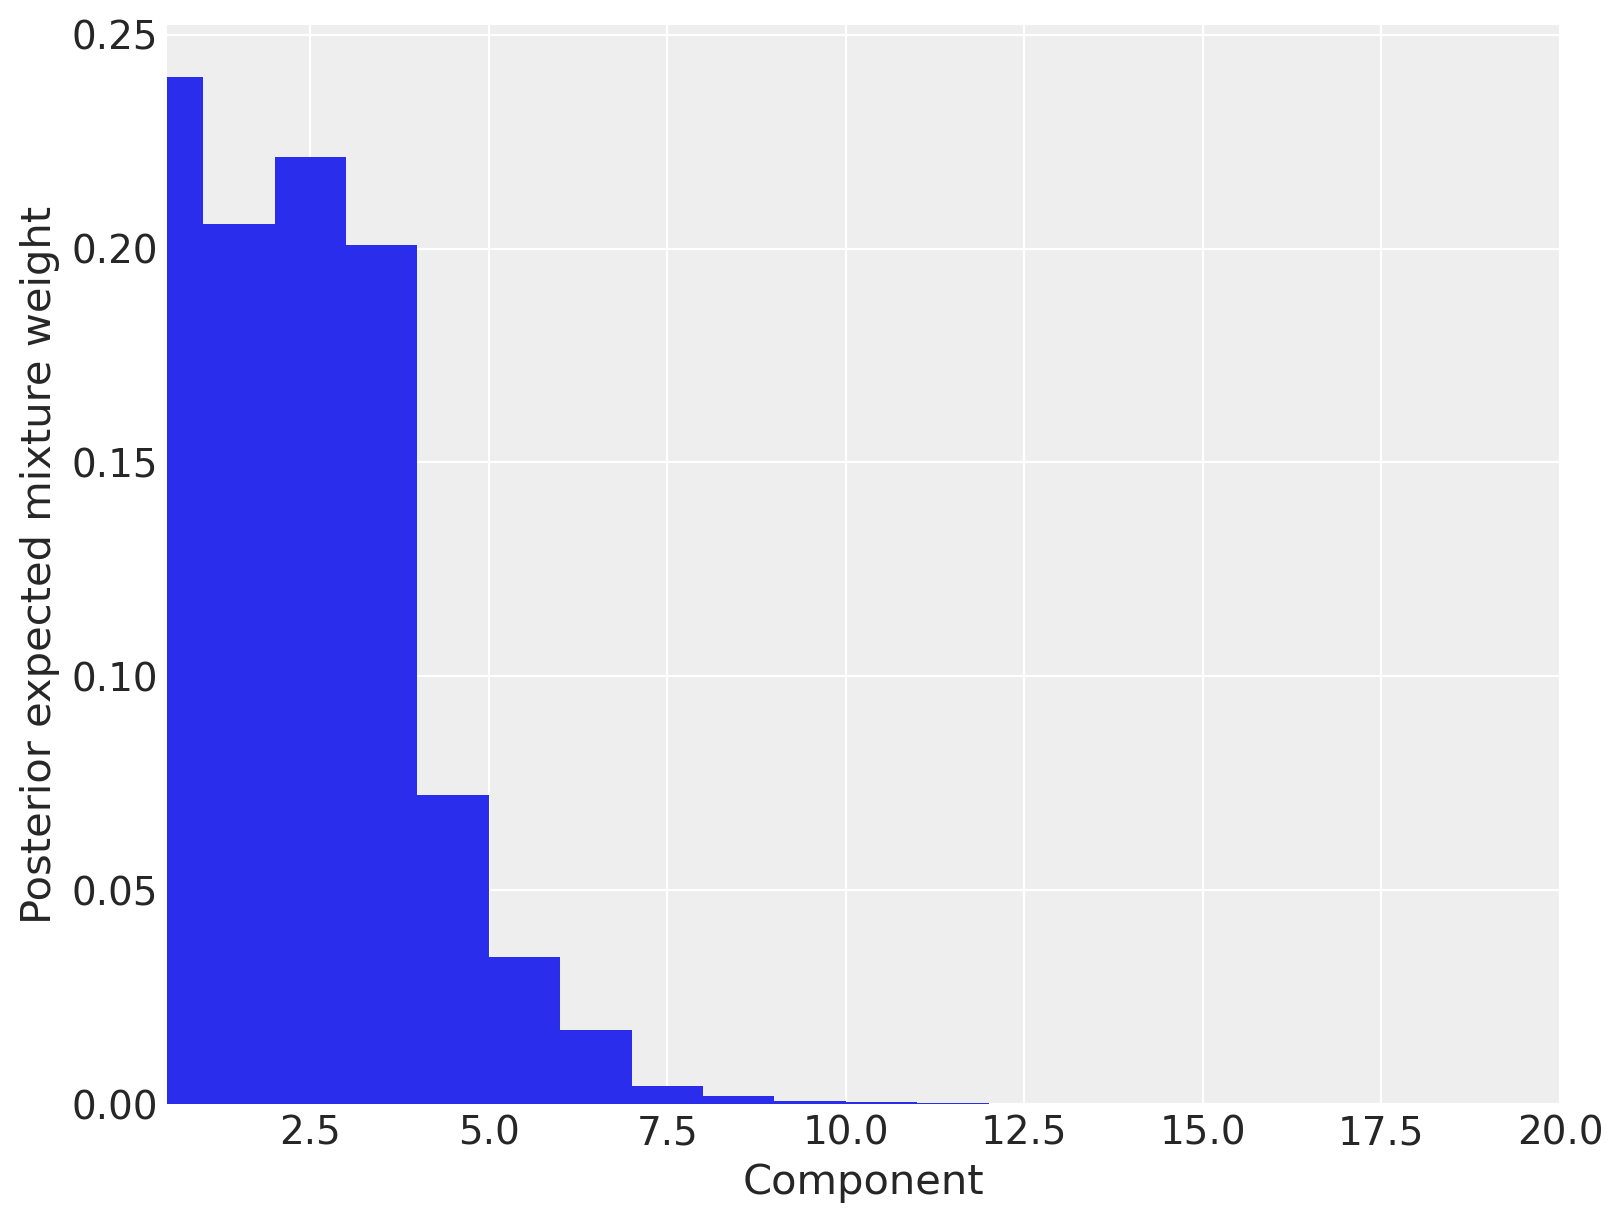

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_w = np.arange(K) + 1
ax.bar(plot_w - 0.5, trace.posterior["w"].mean(("chain", "draw")), width=1.0, lw=0)
ax.set_xlim(0.5, K)
ax.set_xlabel("Component")
ax.set_ylabel("Posterior expected mixture weight");

In [10]:
x_plot = x_plot = xr.DataArray(np.linspace(-3, 12, 200), dims=["plot"])
post_samples = az.extract(trace, num_samples=4)

post_pdf_contribs = xr.apply_ufunc(
    sp.stats.norm.pdf,
    x_plot,
    trace.posterior["mu"],
    trace.posterior["sigma"],
)

post_pdfs = (trace.posterior["w"] * post_pdf_contribs).sum(dim=("component"))

post_pdf_quantiles = post_pdfs.quantile([0.1, 0.9], dim=("chain", "draw"))

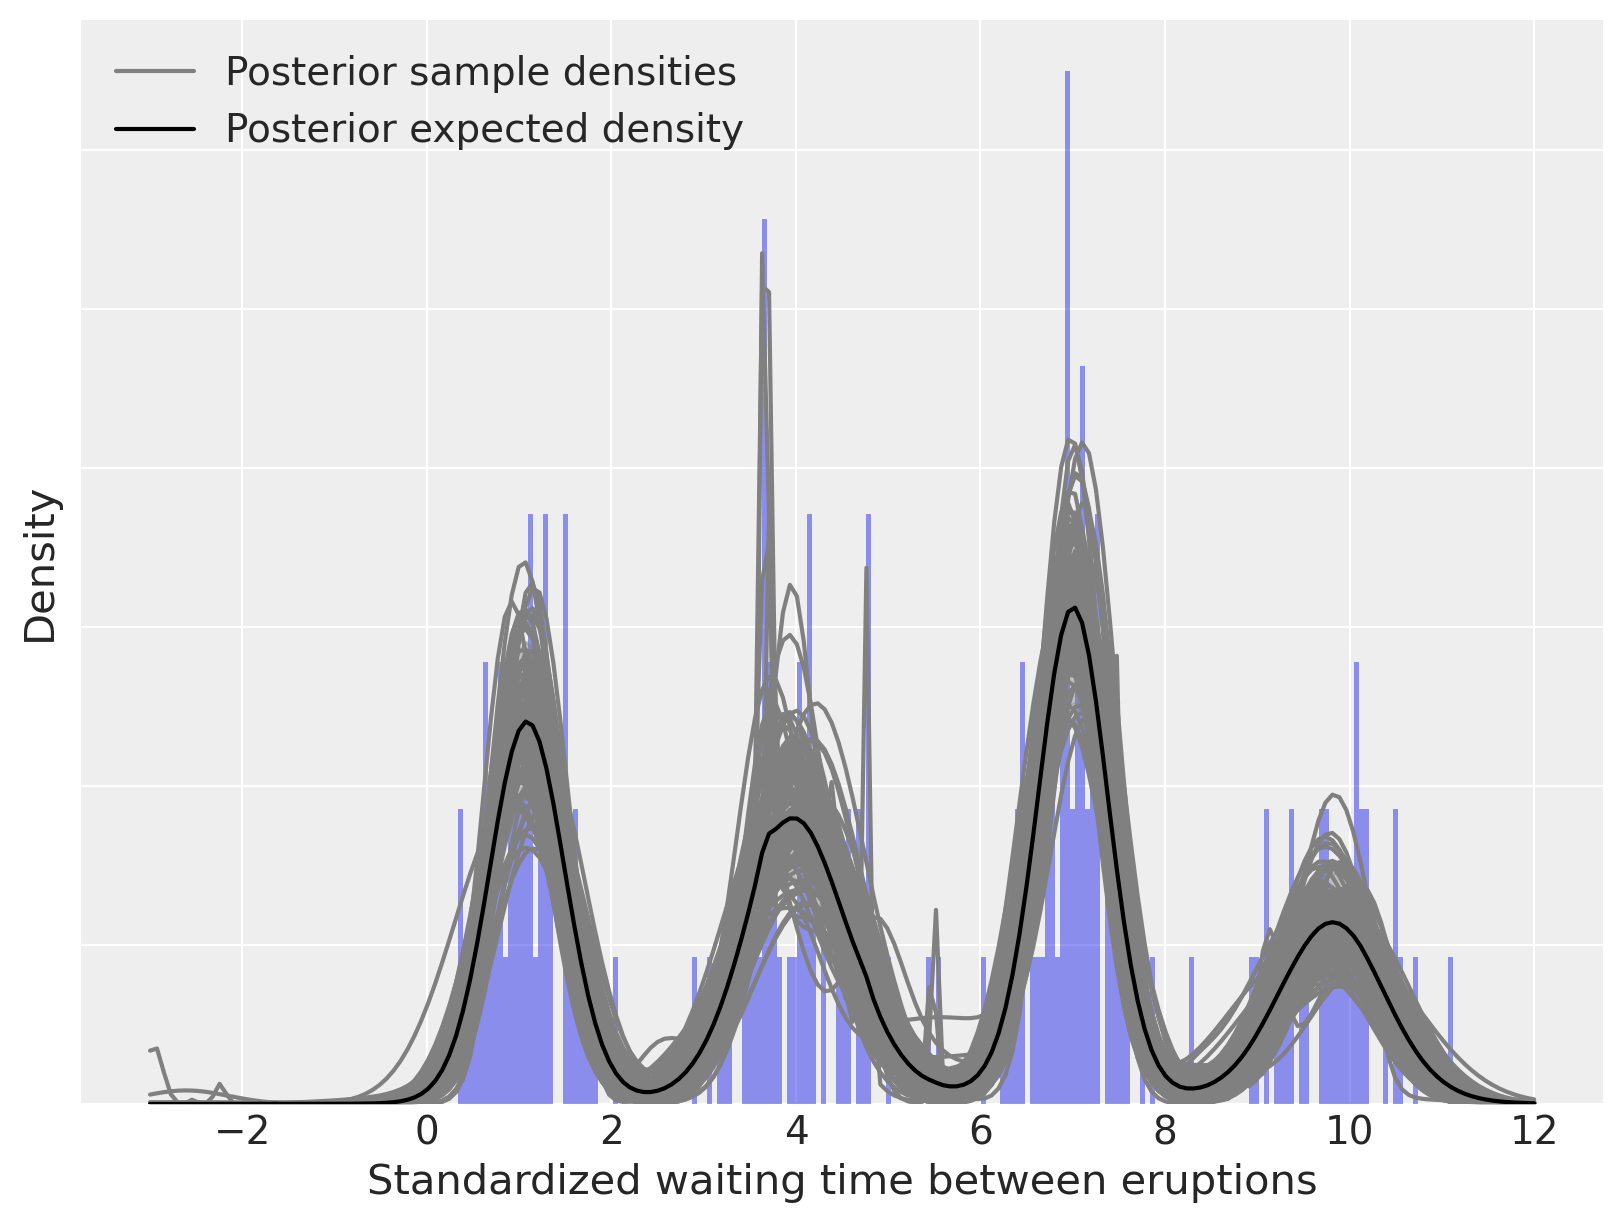

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 200
ax.hist(y, bins=n_bins, density=True, color="C0", lw=0, alpha=0.5)

ax.fill_between(
    x_plot,
    post_pdf_quantiles.sel(quantile=0.1),
    post_pdf_quantiles.sel(quantile=0.9),
    color="gray",
    alpha=0.45,
)

ax.plot(x_plot, post_pdfs.sel(chain=0, draw=0), c="gray", label="Posterior sample densities")
ax.plot(
    x_plot,
    az.extract(post_pdfs, var_names="x", num_samples=100),
    c="gray",
)
ax.plot(x_plot, post_pdfs.mean(dim=("chain", "draw")), c="k", label="Posterior expected density")

ax.set_xlabel("Standardized waiting time between eruptions")

ax.set_yticklabels([])
ax.set_ylabel("Density")

ax.legend(loc=2);